# Table of Contents
 <p><div class="lev1 toc-item"><a href="#PCA" data-toc-modified-id="PCA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PCA</a></div><div class="lev1 toc-item"><a href="#Robust-Regressions" data-toc-modified-id="Robust-Regressions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Robust Regressions</a></div><div class="lev2 toc-item"><a href="#Figure-3-and-8" data-toc-modified-id="Figure-3-and-8-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 3 and 8</a></div><div class="lev1 toc-item"><a href="#Heatmap" data-toc-modified-id="Heatmap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Heatmap</a></div><div class="lev1 toc-item"><a href="#Figure-4A" data-toc-modified-id="Figure-4A-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 4A</a></div><div class="lev1 toc-item"><a href="#Making-the-Genetic-Graph,-Figure-4b" data-toc-modified-id="Making-the-Genetic-Graph,-Figure-4b-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Making the Genetic Graph, Figure 4b</a></div>

In this notebook, we focus on developing the idea that whole-organism RNA-seq contains sufficient information to predict interactions between genes, and we will make some graphs, namely a PCA graph, that motivates the idea that epistasis can be measured genome-wide.

First, I will load a number of useful libraries. Notable libraries to load are `genpy`, a module that contains useful graphing functions tailored specifically for this project and developed by us; `morgan` a module that specifies what a Morgan object and a McClintock object are, and `gvars`, which contains globally defined variables that we used in this project.

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

import genpy
import gvars
import morgan as morgan

# stats
import sklearn.decomposition
import statsmodels.api as stm

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# bayes and mcmc
import pymc3 as pm

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

Next, I will specify my q-value cutoff. A typical value for RNA-seq datasets is q=0.1 for statistical significance. I will also initialize a `genvar.genvars` object, which contains all of the global variables used for this project.

In [2]:
q = 0.1
genvar = gvars.genvars()

Next, I will prepare to initialize a Morgan project. Morgan objects have a large number of attributes. I wrote the Morgan library, but over the past year it has become deprecated and less useful. We will load it here, but it's a bit messy. I am in the process of cleaning it up.

So what does a Morgan object do?

Well, when you initialize a Morgan object, you must pass at least a set of 4 strings. These strings are, in order, the column where the isoform names (unique) reside, the name of the column that holds the regression coefficient from sleuth; the name of the column that holds the TPM values passed by Kallisto and the name of the column that holds the q-values.

Next, we can add what I call a genmap. A genmap is a file that maps read files to genotypes. A genmap file has three columns: 'project_name', 'genotype' and 'batch' in that exact order. For this project, the genotypes are coded. In other words, they are letters, 'a', 'b', 'd',... and not specific genotypes. The reason for this is that we wanted to make sure that, at least during the initial phase of the project, I could not unduly bias the results by searching the literature and what not.  Because the genotypes are coded, we need to specify which of the letters represent single mutants, and which letters represent double mutants. I also need to be able to figure out what the individual components of a double mutant are. Finally, we need to set the q-value threshold. If no q-value is specified, the threshold defaults to 0.1.

I will now initialize the object. I call it thomas.

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# set qvalue
thomas.set_qval()

Ok. Our Morgan object is up and running, but it doesn't have any data yet. So now, we need to specify where the object can look for the Sleuth outputs (`sleuth_loc`)and the Kallisto outputs (`kallisto_loc`). After we have specified these directories, we just let thomas loose in the directories. We will load the files into dictionaries:
`{g1: df_beta1,..., gn: df_betan}`


In [4]:
# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth_all_adjusted/kallisto/'

thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

Great. Now we have loaded all the dataframes that contain TPM information (all 27 of them) and we have loaded the dataframes that contain the regression coefficients for each gene. However, the dataframes with the beta coefficients have plenty of NaNs. Applying thomas.filter_data() will drop them all. I also initialize a `genes` variable that basically holds fancy string names for each genotype in the order they exist within `thomas`.

In [5]:
thomas.filter_data()
# labelling var:
genes = [genvar.fancy_mapping[x] for x in thomas.single_mutants]

Finally, we will go ahead and make a tidy version of our data. Although we will be dealing with the Morgan object for some things, I have found it far easier to work with the tidied dataframe over time. In the tidy_data dataframe, each row is an observation.

In [6]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]
tidy_data = pd.concat(frames)

# take a look at it:
tidy_data.head()

,index,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,genotype,code
0,17319,17320,2L52.1,0.930458,1.000000,-0.052886,0.606018,2.367615,1.561587,0.236560,0.169679,0.314326,0.314326,NaN,NaN,\emph{rhy-1},e
1,7260,7261,2RSSE.1a,0.271026,0.697366,0.778026,0.706845,2.553185,1.452565,0.481532,-0.259473,0.267913,0.267913,WBGene00007064,2RSSE.1,\emph{rhy-1},e
4,7455,7456,3R5.1a,0.283604,0.710627,1.797754,1.676607,2.414674,4.287765,1.381091,2.835425,0.301874,2.835425,WBGene00007065,pot-3,\emph{rhy-1},e
5,1155,1156,3R5.1b,0.000530,0.008558,-3.296362,0.951354,3.813222,2.074825,1.272523,-0.323145,0.085089,0.085089,WBGene00007065,pot-3,\emph{rhy-1},e
13,16497,16498,AC3.10,0.883323,0.998112,0.057975,0.395040,3.090031,2.466209,0.056133,0.177951,0.166948,0.177951,WBGene00004964,spe-10,\emph{rhy-1},e


# PCA

First, we will perform an exploratory procedure, PCA, to demonstrate that transcriptomic signatures from whole-organism RNA-seq have valuable information regarding genetic interactions.

First, I will identify the set of genes that is differentially expressed in at least one genotype. Then, for each genotype I will find what $\beta$  values have an associated q-value that is significant and which ones are not. Set all $\beta$ values that are not statistically significantly different from 0 equal to 0. Finally, we will standardize each genotype so that the collection $\beta$ values for each genotype has a mean of zero and standard deviation of 1. 

In [7]:
max_overlap = tidy_data[tidy_data.qval < q].target_id.unique()
print('There are {0} isoforms that are DE in at least one genotype in this analysis'.format(len(max_overlap)))

grouped = tidy_data.groupby('code')
bvals = np.array([])
labels = []

for code, group in grouped:
    # find names:
    names = group.target_id.isin(max_overlap)
    # extract (b, q) for each gene
    bs = group[names].b.values
    qs = group[names].qval.values
    
    # find sig genes:
    inds = np.where(qs > q)
    # set non-sig b values to 0
    bs[inds] = 0
    #standardize bs
    bs = (bs - bs.mean())/(bs.std())
    
    # place in array
    if len(bvals) == 0:
        bvals = bs
    else:
        bvals = np.vstack((bvals, bs))
    # make a label array
    labels +=  [code]

There are 5671 isoforms that are DE in at least one genotype in this analysis


Next, we initialize the PCA object, specifying that we want to project the data onto two axes. Finally, we plot.

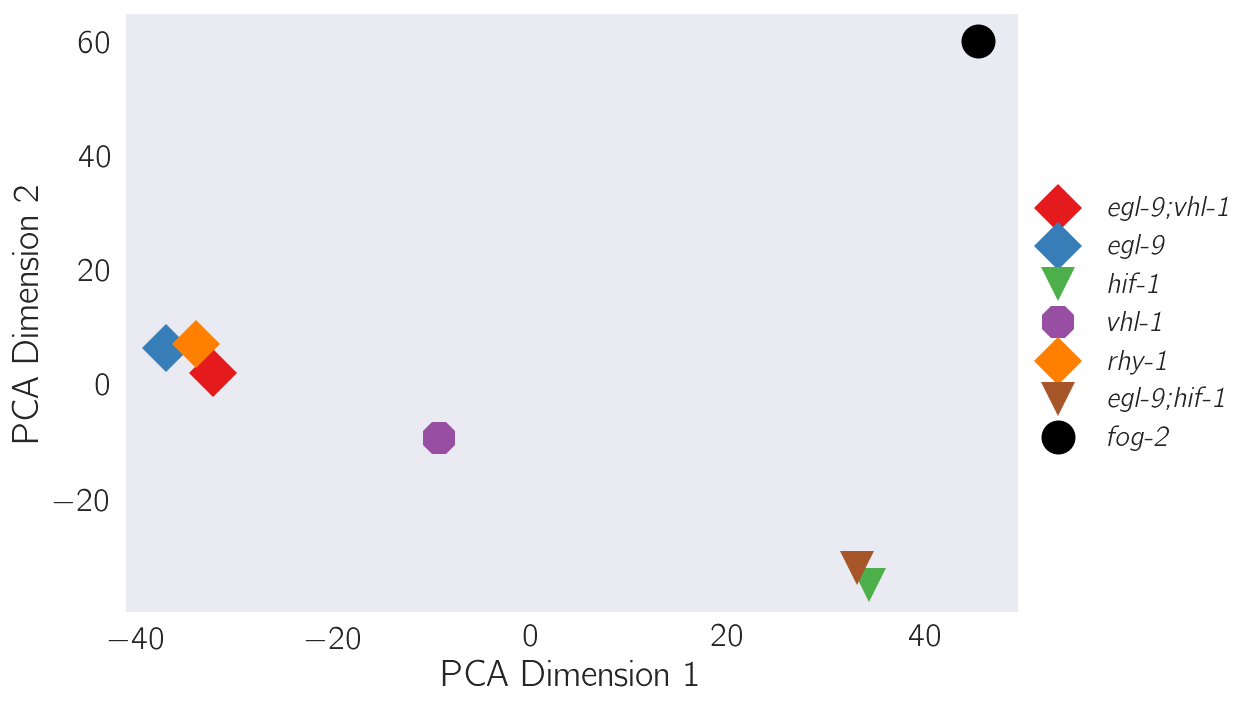

In [8]:
# initialize the PCA object and fit to the b-values
sklearn_pca = sklearn.decomposition.PCA(n_components=2).fit(bvals)
coords = sklearn_pca.fit(bvals).transform(bvals)

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', 'k']
shapes = ['D', 'D', 'v', '8', 'D', 'v', 'o']

# go through each pair of points and plot them:
for i, array in enumerate(coords):
    l = genvar.fancy_mapping[labels[i]]
    plt.plot(array[0], array[1], shapes[i], color=colors[i], label=l, ms=17)

# plot prettify:
plt.legend(loc=(1, 0.25))
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.savefig('../output/PCA_genotypes.svg', bbox_inches='tight')

We can see that the diamonds all cluster together and triangles cluster together. The triangles are HIF-1$^-$ genotypes, whereas the diamonds (and purple octagon) are HIF-1$^+$ genotypes. The *fog-2* mutant is far away from genes in this pathway. The closeness of the *egl-9;hif-1(lf)* mutant to the *hif-1* double mutant suggests to me that epistasis can be measured genome-wide. 

# Robust Regressions

Next, I illustrate how we will perform robust regressions for this dataset. I will use [PyMC3](https://pymc-devs.github.io/pymc3/notebooks/getting_started.html) to perform a robust regression. 

The recipe is as follows:
1. Choose two genotypes to compare, and find D.E. isoforms common to both. This is the set of isoforms to use from now on.
2. Rank the isoforms by $\beta$.
3. Perform a Student-T regression on the data.
4. Find the outliers to the regression, and perform a second regression on them. 
5. Plot the primary regression. If the secondary regression is of opposite value to the primary, plot that too.

In the cell below, I have selected two letters, `e` and `b`. I will find the isoforms that are differentially expressed in both genotypes. Then I will rank the $\beta$ coefficients for the remaining isoforms.

In [9]:
# the genotypes to compare
letters = ['e', 'd']
sig = tidy_data[(tidy_data.code.isin(letters)) & (tidy_data.qval < q)]
grouped = sig.groupby('target_id')
genes = []

# find the intersection between the two.
for target, group in grouped:
    # make sure the group contains all desired genotypes
    all_in = (len(group.code.unique()) == 2)
    if all_in:
        genes += [target]

# extract a temporary dataframe with all the desired genes
temp = tidy_data[tidy_data.target_id.isin(genes)]

# split the dataframes and find the rank of each gene
ovx = genpy.find_rank(temp[temp.code == letters[0]])
ovy = genpy.find_rank(temp[temp.code == letters[1]])

Having found the rank of the data, we will perform the MCMC by calling a function I wrote, called `robust regress`.

Then, we will find the outliers to that regression and we will perform a secondary regression.

In [10]:
# Place data into dictionary:
data = dict(x=ovx.r, y=ovy.r)
x = np.linspace(ovx.r.min(), ovx.r.max())

# perform the simulation
trace_robust = genpy.robust_regress(data)

# find inliers, and outliers
outliers = genpy.find_inliers(ovx, ovy, trace_robust)

# run a second regression on the outliers
data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r,
             y=ovy[ovy.target_id.isin(outliers)].r)

trace_robust2 = genpy.robust_regress(data2)
slope2 = trace_robust2.x.mean()

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec

## Figure 3 and 8

Now we can plot the results. Figures 3 & 8 were generated using this code. 

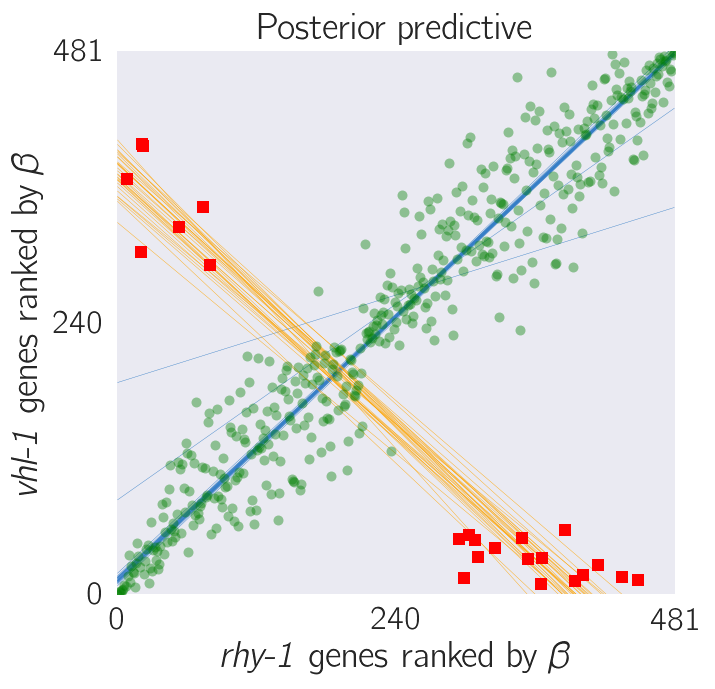

In [11]:
# draw a figure
plt.figure(figsize=(5, 5))

# plot mcmc results
label = 'posterior predictive regression lines'
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label=label, color='#357EC7')

# only plot secondary slope if it's of opposite sign to first
slope = trace_robust.x.mean()
if slope2*slope < 0:
    pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                     label=label, color='#FFA500')

# plot the data 
ind = ovx.target_id.isin(outliers)
x = ovx[~ind].r
y = ovy[~ind].r
plt.plot(x, y, 'go', ms = 5, alpha=0.4, label='inliers')

x = ovx[ind].r
y = ovy[ind].r
plt.plot(x, y, 'rs', ms = 6, label='outliers')

# prettify plot
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, np.floor(len(ovx)/2), len(ovx)])
plt.xticks([0, np.floor(len(ovx)/2), len(ovx)])
plt.xlabel(genvar.fancy_mapping[letters[0]] + r' genes ranked by $\beta$')
plt.ylabel(genvar.fancy_mapping[letters[1]] + r' genes ranked by $\beta$')

comp = letters[0] + letters[1]
plt.savefig('../output/multiplemodes-{0}.svg'.format(comp), bbox_inches='tight')

In [12]:
message = """The average slope of the robust regression was {0:.2g}"""
print(message.format(slope))

The average slope of the robust regression was 0.96


# Heatmap

We can automate and repeat the process above for every pairwise combination in this dataset. I automated this process and stored it the `morgan` library, which defines an object `mcclintock` that does exactly this. 

In [13]:
barbara = morgan.mcclintock('bayesian', thomas, progress=False)


starting comparison of e, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of e, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec
starting comparison of e, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
starting comparison of e, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.1 sec
starting comparison of d, g
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
starting comparison of d, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-------------

# Figure 4A

I will plot the results in a heatmap for easy visualization. This is Figure 4A in the paper. 

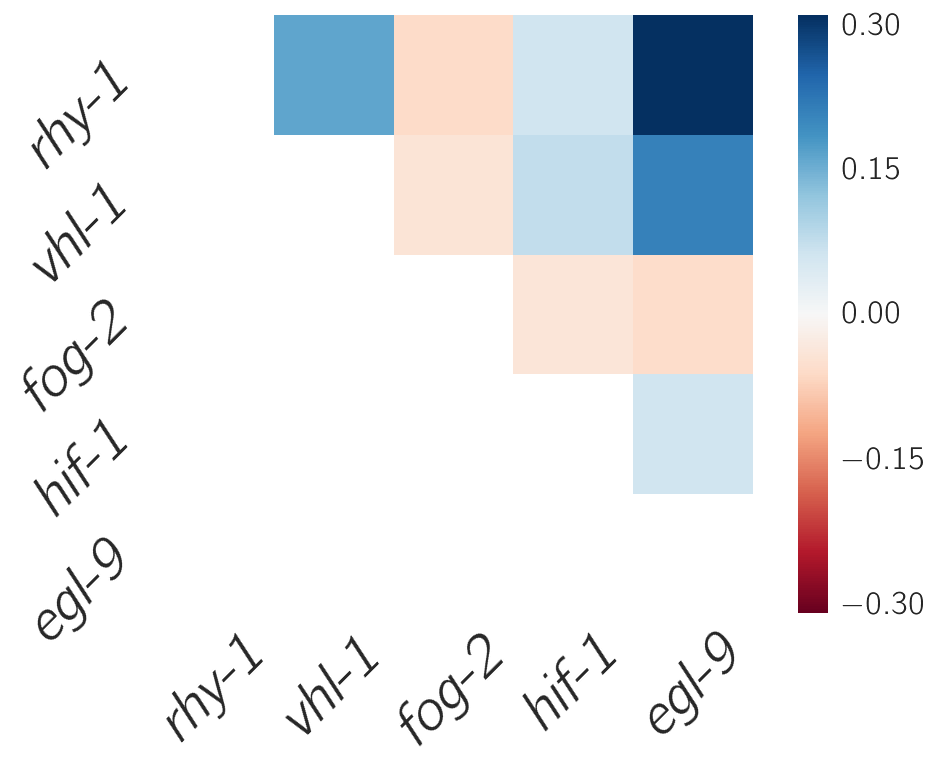

In [14]:
mat = barbara.robust_slope.as_matrix(columns=thomas.single_mutants)
labels = [genvar.fancy_mapping[x] for x in barbara.robust_slope.corr_with.values]

genpy.tri_plot(mat, labels)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('../output/bayes_primary_single_mutants.pdf',
            bbox_inches='tight')

# Making the Genetic Graph, Figure 4b

Another (equivalent) way of displaying the data is to build a network, where the edge thickness or the edge color provide information about the strength of the correlation. We do that below.

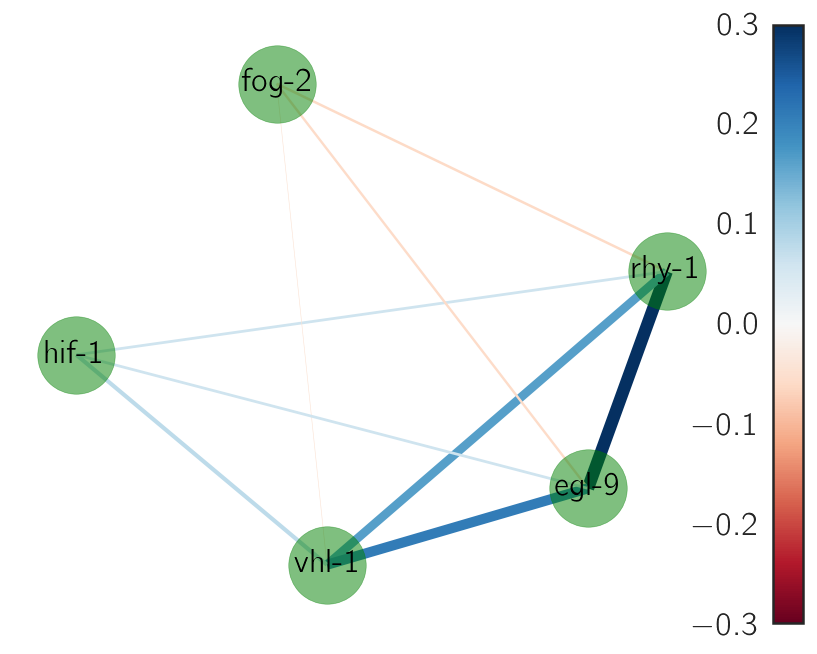

In [15]:
# make the graph:
G, width, weights, elarge = genpy.make_genetic_graph(barbara.robust_slope, w=3)

# paint the canvas:
with sns.axes_style('white'):
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)  # positions for all nodes
    # draw the nodes:
    nx.draw_networkx_nodes(G, pos, node_size=1500,
                           node_color='g', alpha=.5)
    # draw the edges:
    edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
                                   width=width, edge_color=weights,
                                   edge_cmap=plt.cm.RdBu,
                                   edge_vmin=-.3, 
                                   edge_vmax=.3)
    # add the labels:
    nx.draw_networkx_labels(G, pos, font_size=16,
                            font_family='sans-serif')

    # add a colorbar:
    fig.colorbar(edges)
    sns.despine()
    sns.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("../output/weighted_graph.pdf") # save as png